In [1]:
import time
import json

import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    Node2VecNodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

from collections import Counter, defaultdict
import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
import utils

In [3]:
v_sets, e_sets, core_targets, ext_targets, core_testing = utils.load_for_jupyter_raw()

Dataset already downloaded. Loading it from file system
LOADING DATA: 0.93 s


# 0. Replace CoreCaseID and ExtCaseID with CSV data

In [4]:
#todo
v_sample = v_sets
e_sample = e_sets

# 0.1 Add Extra Features: Node Degree (see Node Degree feature notebook)

In [5]:
source_data = e_sets.groupby('from_id').count().to_id
source_data = pd.DataFrame(source_data)
source_data = source_data.rename(columns={'to_id': 'source_degree'})
source_data = source_data.rename_axis('node_id')

target_data = e_sets.groupby('to_id').count().from_id
target_data = pd.DataFrame(target_data)
target_data = target_data.rename(columns={'from_id': 'target_degree'})
target_data = target_data.rename_axis('node_id')

v_sample = pd.merge(v_sample, source_data, left_index=True, right_index=True, how='left')
v_sample = pd.merge(v_sample, target_data, left_index=True, right_index=True, how='left')

v_sample['source_degree'] = v_sample['source_degree'].fillna(0)
v_sample['target_degree'] = v_sample['target_degree'].fillna(0)

# 0.2 Preprocess data

In [6]:
## Preprocessing pipeline

v_sample.CoreCaseGraphID = v_sample.CoreCaseGraphID.fillna(0)
v_sample.ExtendedCaseGraphID = v_sample.ExtendedCaseGraphID.fillna(0)
v_sets = defaultdict()
for v_type in list(pd.Categorical(v_sample.Label).categories):
    v_sets[v_type] = v_sample[v_sample.Label == v_type]
    v_sets[v_type] = v_sets[v_type].drop(['Label']+list(v_sets[v_type].columns[v_sets[v_type].isnull().all()]), axis=1)
    v_sets[v_type].testingFlag = v_sets[v_type].testingFlag.fillna(-1)

e_sets = defaultdict()
for e_type in list(pd.Categorical(e_sample.Label).categories):
    e_sets[e_type] = e_sample[e_sample.Label == e_type]
    e_sets[e_type] = e_sets[e_type].drop(['Label']+list(e_sets[e_type].columns[e_sets[e_type].isnull().all()]), axis=1)
    e_sets[e_type] = e_sets[e_type].rename(columns={'from_id':'source', 'to_id':'target'})
    
#? 3: Logical conversion of categorical features

#Revenue Size Flag: low, mid_low, medium, mid_high, high -> 1,2,3,4,5
conversion = {'low':1, 'mid_low':2, 'medium':3, 'mid_high':4, 'high':5}
for i in v_sets:
    if 'Revenue Size Flag' in list(v_sets[i].columns):
        v_sets[i]['Revenue Size Flag']=v_sets[i]['Revenue Size Flag'].map(conversion)

#Income Size Flag: low, medium, high -> 1,2,3
conversion = {'low':1, 'medium':2, 'high':3}
for i in v_sets:
    if 'Income Size Flag' in list(v_sets[i].columns):
        v_sets[i]['Income Size Flag']=v_sets[i]['Income Size Flag'].map(conversion)

#Similarity Strength: weak, medium, strong -> 1,2,3
conversion = {'weak':1, 'medium':2, 'strong':3}
for i in e_sets:
    if 'Similarity Strength' in list(e_sets[i].columns):
        e_sets[i]['Similarity Strength']= e_sets[i]['Similarity Strength'].map(conversion)
        e_sets[i] = e_sets[i].rename(columns={'Similarity Strength':'weight'})

#Amount Flag: small, medium, large -> 1,50,500 -> treated as weights
conversion = {'small':1, 'medium':50, 'large':500}
for i in e_sets:
    if 'Amount Flag' in list(e_sets[i].columns):
        e_sets[i]['Amount Flag']=e_sets[i]['Amount Flag'].map(conversion)
        e_sets[i] = e_sets[i].rename(columns={'Amount Flag':'weight'})

#? 4: One-hot encoding for categorical features

# get_dummies for one-hot encoding
for i in v_sets:
    if 'Person or Organisation' in list(v_sets[i].columns):
        v_sets[i] = pd.get_dummies(v_sets[i], columns=['Person or Organisation'])

#? 5: String features

# Attempt 1: remove them
for i in v_sets:
    if 'Account ID String' in list(v_sets[i].columns):
        v_sets[i] = v_sets[i].drop('Account ID String', axis=1)
    if 'Address' in list(v_sets[i].columns):
        v_sets[i] = v_sets[i].drop('Address', axis=1)
    if 'Name' in list(v_sets[i].columns):
        v_sets[i] = v_sets[i].drop('Name', axis=1)

In [7]:
v_sets['Account']

,Revenue Size Flag,CoreCaseGraphID,ExtendedCaseGraphID,testingFlag,source_degree,target_degree
node_id,,,,,,
1502000,4,0.0,0.0,-1.0,2.0,7.0
1502001,1,0.0,0.0,-1.0,3.0,5.0
1502002,1,2492.0,0.0,0.0,5.0,6.0
1502003,4,0.0,0.0,-1.0,5.0,11.0
1502004,1,0.0,0.0,-1.0,3.0,3.0
...,...,...,...,...,...,...
15020149208,1,0.0,0.0,-1.0,0.0,1.0
15020149211,4,0.0,0.0,-1.0,0.0,1.0
15020151147,2,0.0,0.0,-1.0,0.0,1.0


In [8]:
# Sort based on testingFlag
for i in v_sets:
    v_sets[i] = v_sets[i].sort_values('testingFlag')
    print(i,":")
    print(v_sets[i].testingFlag.value_counts())
    v_sets[i] = v_sets[i].drop('testingFlag', axis=1)

Account :
-1.0    126863
 0.0     13769
 1.0      1244
Name: testingFlag, dtype: int64
Address :
-1.0    28432
 0.0     1568
Name: testingFlag, dtype: int64
Customer :
-1.0    42127
 0.0    13650
 1.0      449
Name: testingFlag, dtype: int64
Derived Entity :
-1.0    27286
 0.0     3925
 1.0       63
Name: testingFlag, dtype: int64
External Entity :
-1.0    55207
 0.0     4757
 1.0       36
Name: testingFlag, dtype: int64


In [9]:
# Removing ExtendedCaseID:

for i in v_sets:
    v_sets[i] = v_sets[i].drop('ExtendedCaseGraphID', axis=1)

v_sets['Account']

,Revenue Size Flag,CoreCaseGraphID,source_degree,target_degree
node_id,,,,
1502000,4,0.0,2.0,7.0
15020057228,3,0.0,6.0,8.0
15020057227,3,0.0,2.0,8.0
15020057226,4,0.0,2.0,5.0
15020057225,3,0.0,6.0,7.0
...,...,...,...,...
15020070563,2,427.0,2.0,4.0
1502002233,1,3549.0,4.0,7.0
15020052758,2,3573.0,4.0,2.0


# 1. Train HinSAGE on all the nodes

Note: Embedding of the Accounts only for this stage. 
It'pretty easy to just repeat the process for other node categories and concatenate the results. For now I am trying with the Accounts.

In [10]:
batch_size = 300
epochs = 30
num_samples = [8, 4]
dropout = 0.5
hinsage_layer_sizes = [32, 32]

In [11]:
G = sg.StellarDiGraph(v_sets, e_sets)

In [12]:
generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

In [13]:
hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'softmax'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

In [14]:
def run_deep_graph_infomax(base_model, generator, epochs):
    t0 = time.time()
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    # Train DGI
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=15)
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    t1 = time.time()
    print(f'Time required: {t1-t0:.2f} s ({(t1-t0)/60:.1f} min)')
    
    return x_emb_in, x_emb_out, model

Epoch 1/30
473/473 [==============================] - 86s 182ms/step - loss: 0.5512
Epoch 2/30
473/473 [==============================] - 85s 180ms/step - loss: 0.4864
Epoch 3/30
473/473 [==============================] - 86s 182ms/step - loss: 0.44323s - loss: 0.4 - ETA
Epoch 4/30
473/473 [==============================] - 85s 179ms/step - loss: 0.39390s - loss: 0.
Epoch 5/30
473/473 [==============================] - 86s 183ms/step - loss: 0.3443
Epoch 6/30
473/473 [==============================] - 96s 204ms/step - loss: 0.3028 ETA: 2s -
Epoch 7/30
473/473 [==============================] - 100s 211ms/step - loss: 0.2638
Epoch 8/30
473/473 [==============================] - 101s 213ms/step - loss: 0.2240
Epoch 9/30
473/473 [==============================] - 95s 201ms/step - loss: 0.20613
Epoch 10/30
473/473 [==============================] - 96s 203ms/step - loss: 0.1960
Epoch 11/30
473/473 [==============================] - 96s 202ms/step - loss: 0.18741s - los
Epoch 12/30
473/473 

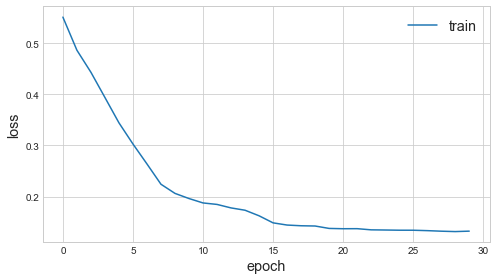

In [15]:
# Run Deep Graph Infomax

x_emb_in, x_emb_out, model = run_deep_graph_infomax(hinsage, generator, epochs=epochs)

# 2. Use the model to predict the embedding of the training and cross validation set

In [16]:
# take the training + cv nodes from v_sets['Account']
# aka the nodes with testingFlag = 0

train_cv_set = v_sets['Account'][126863:126863+13769]
train_cv_set

,Revenue Size Flag,CoreCaseGraphID,source_degree,target_degree
node_id,,,,
15020041132,3,0.0,5.0,6.0
15020041134,4,0.0,3.0,8.0
15020058888,5,0.0,5.0,5.0
15020021707,4,3060.0,6.0,8.0
15020022245,3,2308.0,4.0,11.0
...,...,...,...,...
15020082878,5,0.0,2.0,9.0
15020028999,4,0.0,7.0,7.0
15020056211,1,1016.0,2.0,8.0


In [17]:
# Perform embeddings on them

emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
train_cv_embs = emb_model.predict(
    generator.flow(train_cv_set.index.values)
)

In [18]:
train_cv_embs[52]

array([1.0720079e-03, 2.4479684e-08, 1.0503706e-16, 4.9975845e-14,
       1.4010843e-06, 4.8874274e-09, 1.8079078e-36, 1.7699774e-09,
       2.5316977e-13, 5.0063586e-06, 2.6038649e-13, 1.4827211e-07,
       1.9948558e-07, 5.7378503e-07, 2.7576447e-14, 8.8008550e-12,
       8.0347995e-13, 5.5432413e-04, 1.9459888e-02, 1.5434988e-02,
       9.4864172e-01, 3.1005269e-01, 0.0000000e+00, 3.1869013e-07,
       2.4653234e-02, 6.3374089e-03, 4.0493400e-05, 2.8109106e-03,
       2.6793033e-02, 0.0000000e+00, 4.2743459e-03, 4.3999333e-02],
      dtype=float32)

# 3. TSNE on train + cv set

In [19]:
train_cv_embs_2d = pd.DataFrame(
    TSNE(n_components=2).fit_transform(train_cv_embs), 
    index=train_cv_set.index.values
)

In [55]:
# Coloring based on ExtendedCaseGraphID

# these are the training+cv indexes
node_ids = train_cv_set.index.values.tolist()

# these are the training+cv Extended case ID
ext_targets_2 = v_sample.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID 

label_map = {l: i*10 for i, l in enumerate(np.unique(ext_targets_2), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets_2]

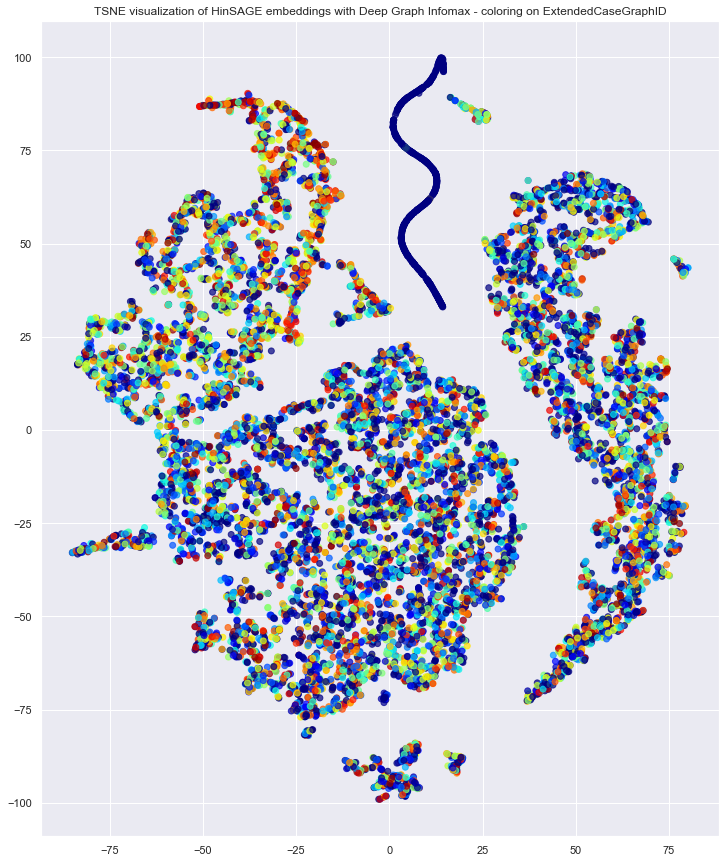

In [56]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    train_cv_embs_2d[0],
    train_cv_embs_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax - coloring on ExtendedCaseGraphID")
plt.show()

In [53]:
# node degree based coloring

# these are the training+cv source degrees
ext_targets_3 = v_sample.loc[[int(node_id) for node_id in node_ids]].source_degree

label_map = {l: i*100 for i, l in enumerate(np.unique(ext_targets_3), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets_3]

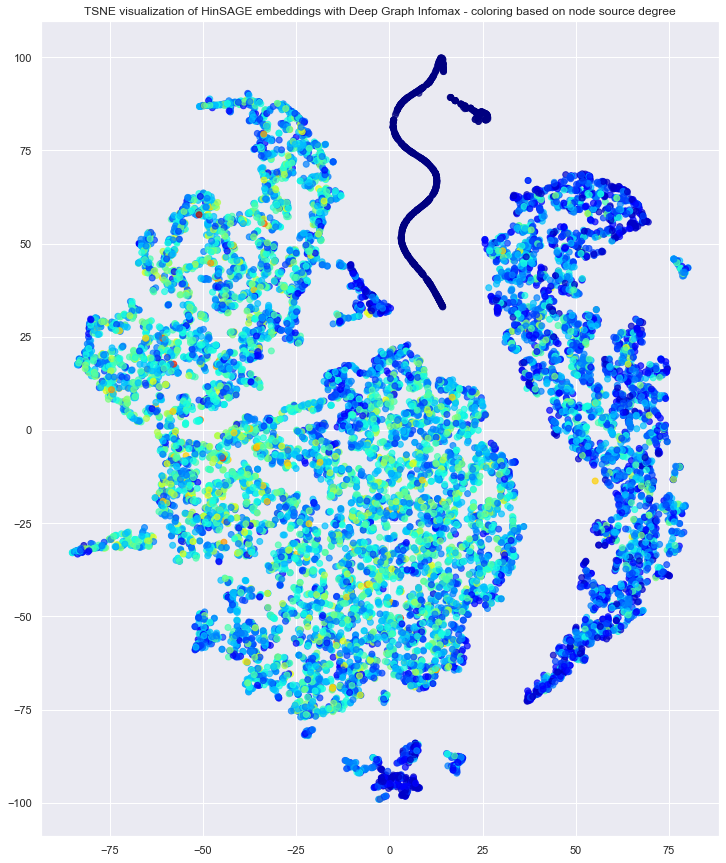

In [54]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    train_cv_embs_2d[0],
    train_cv_embs_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax - coloring based on node source degree")
plt.show()

In [59]:
# account core case ID based coloring

# these are the training+cv core case IDs
ext_targets_5 = v_sample.loc[[int(node_id) for node_id in node_ids]]['CoreCaseGraphID']

label_map = {l: i*100 for i, l in enumerate(np.unique(ext_targets_5), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets_5]

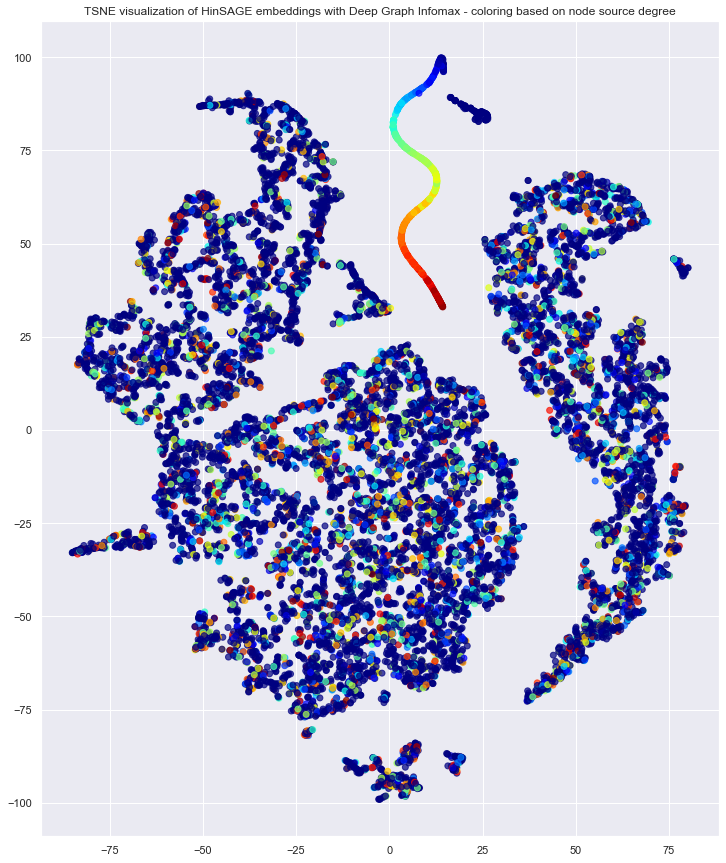

In [60]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    train_cv_embs_2d[0],
    train_cv_embs_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax - coloring based on node source degree")
plt.show()

# 4. Create training and cross validation sets

Note: I am not using fancy splitting methods since I want to keep track of the order of the nodes. 

In [22]:
# very rudimentary and shitty splitting:

n_embs = train_cv_embs.shape[0]

train_set = train_cv_embs[:10000]
train_labels = ext_targets_2.values[:10000]

cv_set = train_cv_embs[-3769:]
cv_labels = ext_targets_2.values[-3769:]

The train_set is nothing more than the embedding of the account nodes of the training set.

This means that I can get the ID of the first node just by incrementing the index of
the train_set by 10000 and look at the train_cv_set dataframe.

In [23]:
# this should be the first node in the train_set
train_cv_set.iloc[0]

Revenue Size Flag    3.0
CoreCaseGraphID      0.0
source_degree        5.0
target_degree        6.0
Name: 15020041132, dtype: float64

In [24]:
# this should be its embeddings
train_set[0]

array([3.3505936e-04, 5.8475962e-08, 2.1784779e-05, 1.7186542e-06,
       7.8607866e-07, 2.4291194e-06, 3.2213626e-07, 1.8063773e-08,
       2.6705398e-05, 1.6343422e-05, 2.3307616e-11, 3.0090760e-07,
       6.1786845e-06, 1.5856148e-06, 1.4457866e-12, 1.5656956e-10,
       1.1306434e-08, 7.3381008e-05, 6.4022525e-04, 2.3972664e-02,
       9.7716266e-01, 1.5567715e-01, 0.0000000e+00, 2.6745303e-04,
       2.7497339e-03, 5.9380690e-03, 3.4564331e-05, 1.9884112e-03,
       5.4433055e-02, 0.0000000e+00, 7.8419823e-04, 1.3165121e-01],
      dtype=float32)

In [25]:
train_labels[0]

3449.0

In [26]:
# the same can be said about the CV set
train_cv_set.iloc[10000]

Revenue Size Flag    5.0
CoreCaseGraphID      0.0
source_degree        6.0
target_degree        3.0
Name: 15020030225, dtype: float64

In [27]:
cv_set[0]

array([9.8745842e-03, 1.5853116e-06, 2.4936199e-03, 1.2415470e-04,
       3.6779489e-05, 1.0873578e-04, 1.6714641e-05, 1.5966327e-07,
       1.1985663e-03, 3.6452297e-04, 3.7355147e-11, 7.5215962e-06,
       3.3418974e-04, 3.0770414e-05, 4.3105437e-12, 9.5074615e-10,
       2.0153179e-06, 2.1691833e-02, 1.5135852e-03, 7.9185247e-02,
       3.2481310e-01, 2.1385410e-01, 0.0000000e+00, 3.0543411e-01,
       2.5730178e-01, 6.5195076e-02, 5.1313629e-03, 8.9188613e-02,
       3.8339499e-01, 0.0000000e+00, 1.3007443e-01, 7.1153206e-01],
      dtype=float32)

In [28]:
cv_labels[0]

135.0

If this is correct, the extended ID of node 15020030225 must be 135.

And the extended ID of node 15020041132 must be 3449.

In [29]:
v_sample.loc[15020030225]

Label                        Account
Revenue Size Flag               high
Account ID String         J9IZ81Wn6B
Address                          NaN
Person or Organisation           NaN
Name                             NaN
Income Size Flag                 NaN
CoreCaseGraphID                    0
ExtendedCaseGraphID              135
testingFlag                        0
source_degree                      6
target_degree                      3
Name: 15020030225, dtype: object

In [30]:
v_sample.loc[15020041132]

Label                        Account
Revenue Size Flag             medium
Account ID String         VATbZc3h3X
Address                          NaN
Person or Organisation           NaN
Name                             NaN
Income Size Flag                 NaN
CoreCaseGraphID                    0
ExtendedCaseGraphID             3449
testingFlag                        0
source_degree                      5
target_degree                      6
Name: 15020041132, dtype: object

Confirmed. The labels are correct.

# 5. Train a classifier to predict ExtendedGraphCaseID

In [31]:
classifiers = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    #'svm1': SVC(kernel='linear'),
    'svm2': SVC(kernel='rbf'),
    #'svm3': SVC(kernel='sigmoid'),
    #'mlp1': MLPClassifier(),
    #'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100]),
    #'ada': AdaBoostClassifier(),
    #'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    #'gbc': GradientBoostingClassifier(),
    #'lr': LogisticRegression(multi_class="auto", solver="lbfgs", max_iter=200)
}

In [32]:
f1_scores = dict()
accs = dict()

for clf_name in classifiers:
    t0 = time.time()
    clf = classifiers[clf_name]
    clf.fit(train_set, train_labels)
    cv_pred = clf.predict(cv_set)
    clf_f1 = f1_score(cv_labels, cv_pred, average='weighted')
    clf_acc = (cv_pred == cv_labels).mean()
    f1_scores[clf_name] = clf_f1
    accs[clf_name] = clf_acc
    t1 = time.time()
    print(f"Classifier: {clf_name} - f1: {clf_f1:.3f} - acc: {clf_acc:.3f} - time: {t1-t0:.0f} s")

Classifier: mnb - f1: 0.102 - acc: 0.253 - time: 0 s
Classifier: gnb - f1: 0.014 - acc: 0.009 - time: 1 s
Classifier: svm2 - f1: 0.102 - acc: 0.253 - time: 316 s
Classifier: rfc - f1: 0.206 - acc: 0.252 - time: 187 s


In [33]:
confusion_matrix = pd.crosstab(
    cv_labels,
    cv_pred,
    rownames=['True'],
    colnames=['Predicted'],
    margins=True
)

In [34]:
np.unique(cv_pred)

array([0.000e+00, 1.000e+00, 1.000e+01, ..., 3.993e+03, 3.994e+03,
       3.995e+03])

# Understanding why it sucks so bad

Clearly, there are many problems.

One of the main ones is the distributions of the labels. The data is severely imbalanced. It makes no sense to train a logistic classifier on data with a class that is 120x times the size of the second biggest class.

Ways to overcome data imbalance for classification:

- Super & Under sampling techniques, like SMOTE and ADASYN
- XGBoost with tuned parameters for imbalanced classification (aka weight classes differently)
- Ensembles: basically parallelizing classifiers that each can manage a small imbalance instead of having a strong imbalance on one classifier.

Another problem is the quality of the embeddings: they are just bad. Some embedded vectors have really obvious forms like all 0's and only one dimension with non-zero value.

And at last: Feature quality. I can't blame the embedding model for producing very bad embeddings when the graph it's using has basically 1 feature per node type. For instance, Account nodes only have the Revenue Size Flag and CoreCase ID. Not enough for producing good results. 

Let's take a look at the labels and predictions:

In [35]:
# training set core case
train_cv_set[:10000].CoreCaseGraphID.value_counts()

0.0       6679
483.0        4
1106.0       4
3496.0       4
68.0         4
          ... 
2147.0       1
662.0        1
2632.0       1
1889.0       1
955.0        1
Name: CoreCaseGraphID, Length: 1930, dtype: int64

In [36]:
# Training set labels (ext case)
pd.DataFrame(train_labels).value_counts()

0.0       2800
333.0       24
120.0       23
3248.0      22
3145.0      21
          ... 
1200.0       1
3721.0       1
1193.0       1
1191.0       1
3327.0       1
Length: 2219, dtype: int64

In [37]:
# cv set core case
train_cv_set[-3769:].CoreCaseGraphID.value_counts()

0.0       2608
2169.0       3
3582.0       3
2365.0       3
107.0        3
          ... 
1469.0       1
2157.0       1
3003.0       1
1588.0       1
2567.0       1
Name: CoreCaseGraphID, Length: 915, dtype: int64

In [38]:
# CV set labels (ext case)
pd.DataFrame(cv_labels).value_counts()

0.0       954
2449.0     13
2424.0     13
2896.0     11
2555.0     11
         ... 
2140.0      1
2138.0      1
2122.0      1
2121.0      1
1848.0      1
Length: 1497, dtype: int64

In [39]:
# CV set predictions
pd.DataFrame(cv_pred).value_counts()

0.0       1396
333.0       17
969.0       11
120.0       11
2030.0      10
          ... 
1946.0       1
1944.0       1
1935.0       1
1927.0       1
1765.0       1
Length: 1123, dtype: int64

In [40]:
confusion_matrix

Predicted,0.0,1.0,10.0,12.0,13.0,17.0,21.0,22.0,24.0,25.0,...,3966.0,3967.0,3969.0,3972.0,3974.0,3983.0,3993.0,3994.0,3995.0,All
True,,,,,,,,,,,,,,,,,,,,,
0.0,943,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,954
1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3984.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3986.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3994.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5


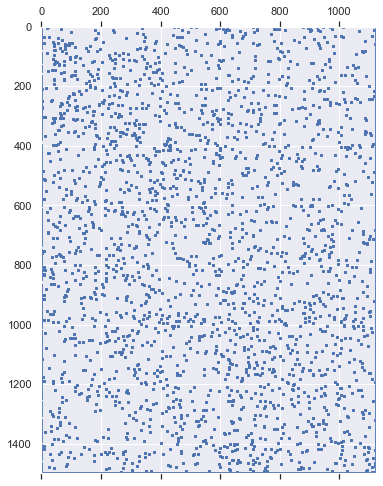

In [41]:
# Sparse confusion matrix visualization

sns.set(rc={'figure.figsize':(6, 10)})
plt.spy(confusion_matrix, precision = 0.1, markersize = 2)